<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/LSTM_stf_python_p7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


El lag con mayor valor absoluto es: 3 con un valor de: -0.08012287748027366

El lag más significativo es: 3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


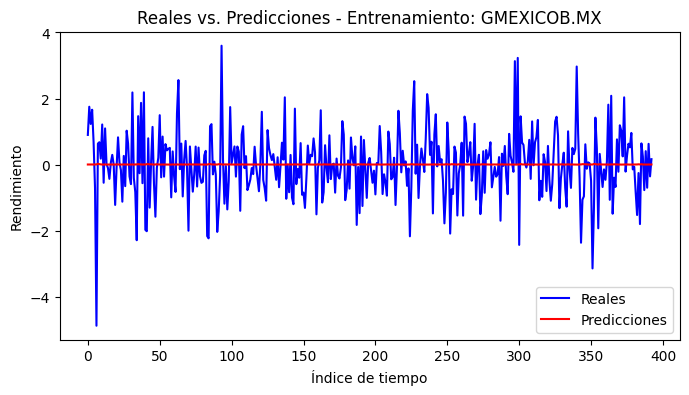

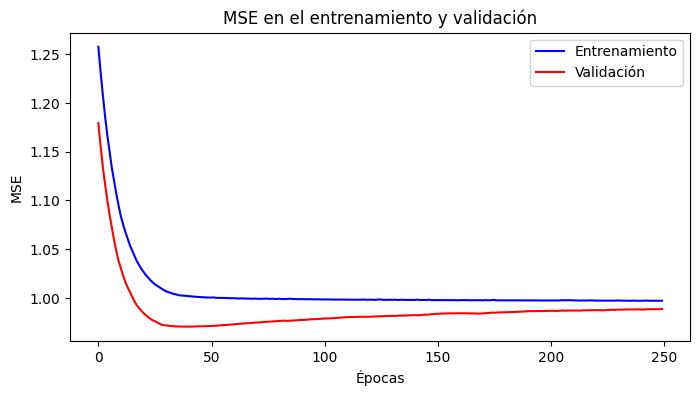

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción invertida para el último dato: [0.08507787]
Valor real del último dato: 1.2494405328322364
Error absoluto: [1.1643627]
Error cuadrático: [1.3557404]


In [4]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from statsmodels.tsa.stattools import acf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

# Función para obtener los datos de Yahoo Finance
def get_yahoo_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Calcular los rendimientos logarítmicos
def calculate_returns(data):
    log_returns = np.log(data['Close'] / data['Close'].shift(1))
    return log_returns.dropna()

# Descargar los datos de Yahoo Finance
ticker = "GMEXICOB.MX"
start_date = "2023-01-01"
end_date = "2024-12-22"
data = get_yahoo_data(ticker, start_date, end_date)

# Calcular los rendimientos logarítmicos
returns = calculate_returns(data)

# Calcular la ACF y obtener el lag más significativo
acf_result = acf(returns, nlags=20)
lags = np.array(range(1, len(acf_result)))
acf_values = acf_result[1:]

# Obtener el lag más significativo
max_abs_lag = np.argmax(np.abs(acf_values))
lag_significant = lags[max_abs_lag]

print(f"\nEl lag con mayor valor absoluto es: {lags[max_abs_lag]} con un valor de: {acf_values[max_abs_lag]}")
print(f"\nEl lag más significativo es: {lag_significant}")

def generate_lagged_data(returns, lag):
    n = len(returns)
    data_matrix = np.zeros((n - lag, lag + 1))
    for i in range(n - lag):
        data_matrix[i, :] = returns[i:i + lag + 1].values.squeeze()
    columns = [f'Lag_{i+1}' for i in range(lag)] + ['Target']
    return pd.DataFrame(data_matrix, columns=columns)

# Generar los datos laggeados
lagged_data = generate_lagged_data(returns, lag_significant)

# Dividir los datos en entrenamiento y validación
train_ratio = 0.8
train_size = int(train_ratio * len(lagged_data))
train_data = lagged_data[:train_size]
validation_data = lagged_data[train_size:]

# Normalizar los datos
def normalize(data):
    return (data - data.mean()) / data.std()

train_data_normalized = train_data.apply(normalize)
validation_data_normalized = validation_data.apply(normalize)

# Separar las características y las etiquetas
X_train = train_data_normalized.iloc[:, :-1].values
y_train = train_data_normalized.iloc[:, -1].values
X_val = validation_data_normalized.iloc[:, :-1].values
y_val = validation_data_normalized.iloc[:, -1].values

# Convertir datos para entrada de LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

input_lag = int(lag_significant)
lstm_lag = input_lag - 1
# Definir la arquitectura del modelo LSTM
model = Sequential([
    Input(shape=(input_lag, 1)),  # Entrada 3D para LSTM
    LSTM(lstm_lag, activation='sigmoid', return_sequences=False),
    Dense(1)
])

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Crear el callback de tqdm para mostrar el progreso
tqdm_callback = TqdmCallback()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[tqdm_callback], verbose=0)

# Graficar los rendimientos reales vs. las predicciones durante el entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(8, 4))
plt.plot(y_train, label='Reales', color='blue')
plt.plot(y_train_pred, label='Predicciones', color='red')
plt.legend()
plt.title(f"Reales vs. Predicciones - Entrenamiento: {ticker}")
plt.xlabel("Índice de tiempo")
plt.ylabel("Rendimiento")
plt.show()

# Graficar el MSE en el entrenamiento y la validación
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.legend()
plt.title("MSE en el entrenamiento y validación")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.show()

# Evaluar el modelo con el último dato
final_test = lagged_data.iloc[-1:, :-1].values
y_final_test = lagged_data.iloc[-1, -1]

final_test = final_test.reshape((final_test.shape[0], final_test.shape[1], 1))

# Hacer la predicción
y_pred_final = model.predict(final_test)

# Invertir la normalización para la predicción final
mean_val = train_data['Target'].mean()
std_val = train_data['Target'].std()
y_pred_final_inverted = (y_pred_final * std_val) + mean_val

# Calcular los errores
error_absoluto = np.abs(y_final_test * 100 - y_pred_final_inverted[0] * 100)
error_cuadratico = (y_final_test * 100 - y_pred_final_inverted[0] * 100) ** 2

print(f"Predicción invertida para el último dato: {y_pred_final_inverted[0] * 100}")
print(f"Valor real del último dato: {y_final_test * 100}")
print(f"Error absoluto: {error_absoluto}")
print(f"Error cuadrático: {error_cuadratico}")